# Global PAth vars

In [ ]:
#PATH 
base_path = "drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset/"
train = f"{base_path}train/"
test = f"{base_path}test/"
Save = f"drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/"

base_path_bin = "drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Dataset/Alzheimers_Dataset_Binary/"
train_bin = f"{base_path_bin}train/" 
test_bin = f"{base_path_bin}test/"
Save_bin = f"drive/MyDrive/Pammy_Alzheimers_Disease_Prediction/Visualisation/BinaryClassification/"


# Imports

In [ ]:
import os, time

#arr operations
import numpy as np

# Progress Bar
from tqdm import tqdm

# Evaluation metrics
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report

#Importing Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D
from keras.layers import GlobalAveragePooling2D, Conv2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback, ReduceLROnPlateau
from keras import optimizers, Input
from keras.utils.vis_utils import plot_model
from keras.applications.imagenet_utils import decode_predictions
import keras.backend as K


#Pretrained models
from keras.applications.xception import Xception
from keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50
from keras.applications.resnet_v2 import ResNet152V2
#from keras.applications.resnet152_v2 import ResNet152V2


#Image read and show
import skimage.io
from skimage.io import imread, imshow
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')
#plt.style.use('fivethirtyeight')

#Metrics
from sklearn.metrics import f1_score , recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from itertools import cycle


In [ ]:
tf.__version__

'2.8.2'

# Multi Class

## Data Generator 

In [ ]:
# Image data generator
training_data_gen = ImageDataGenerator(
        rescale = 1./255,
        validation_split = 0.2,           
        )
testing_data_gen = ImageDataGenerator(rescale = 1./255)
validation_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

## Splitting the Data

In [ ]:
#Constants 
Image_Size = 256
Batch_size = 32

training_data = training_data_gen.flow_from_directory(
    directory= train,
    target_size = (Image_Size,Image_Size),
    class_mode = 'categorical',
    subset = 'training',
    batch_size = Batch_size)

validation_data = validation_data_gen.flow_from_directory(
  directory = train,
  target_size = (Image_Size,Image_Size),
  class_mode = 'categorical',
  subset = 'validation',
  batch_size = Batch_size)

testing_data =  testing_data_gen.flow_from_directory(
  directory = test,
  target_size = (Image_Size,Image_Size),
  class_mode = 'categorical',
  batch_size = Batch_size
)

Found 4098 images belonging to 4 classes.
Found 1023 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Total Number of samples in train, test and validation data

In [ ]:
print(f"Total number of samples in training set : {training_data.n}")
print(f"Total number of samples in testing set : {testing_data.n}")
print(f"Total number of samples in validation set  : {validation_data.n}")

Total number of samples in training set : 4098
Total number of samples in testing set : 1279
Total number of samples in validation set  : 1023


## Count_plot - A function to create a barplot of class counts

In [ ]:
def Count_plot(title, SavePath, fname):
  Count = {
      'Training'     : training_data.n, 
      'Testing'      : validation_data.n, 
      'Validation'   : testing_data.n,
      }

  keys = list(Count.keys())
  values = list(Count.values())  
  fig = plt.figure(figsize = (10, 5))
  plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)
  plt.title(f"{title}")
  plt.savefig(f"{SavePath}{fname}")

## Bar plot showing the number of samples in Train, Test and Validation split of the data.

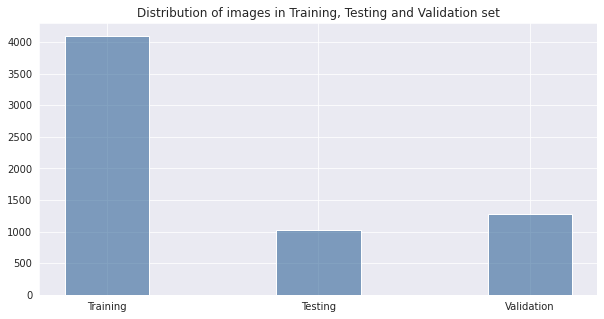

In [ ]:
Count_plot("Distribution of images in Training, Testing and Validation set", Save, "Image_Distrib_1.jpeg")

## Set Class Names 

In [ ]:
class_Names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
training_data.class_names = class_Names
validation_data.class_names = class_Names
testing_data.class_names = class_Names

## Check to ensure training, testing and validation set has more than 5 batches

In [ ]:
assert len(training_data) > 5, "Less Than 5 Batches"
assert len(validation_data) > 5, "Less Than 5 Batches"
assert len(testing_data) > 5, "Less Than 5 Batches"

## Image_Label_Group - A function to sample some number of data/images and their labels from input data (Could be batch training, testing or validation set). 

In [ ]:
def Image_Label_Group(X):
  
  sample_Images = []
  sample_Image_labels = []

  for _ in range(5):
    x,y = X.next()
    random_ints = random_ints = np.random.choice(range(0,32), 5)
    for i in random_ints:
      sample_Images.append(x[i])
      sample_Image_labels.append(y[i])
  
  return sample_Images, sample_Image_labels

## Sampling images and labels from train, test and validation set

In [ ]:
Train_Sample_Images, Train_Sample_labels = Image_Label_Group(training_data)
Test_Sample_Images, Test_Sample_labels = Image_Label_Group(testing_data)
Valid_Sample_Images, Valid_Sample_labels = Image_Label_Group(validation_data)

## Check to ensure sampling was performed correctly

In [ ]:
assert len(Train_Sample_Images) == 25
assert len(Test_Sample_Images) == 25
assert len(Valid_Sample_Images) == 25
assert len(Train_Sample_labels) == 25
assert len(Test_Sample_labels) == 25
assert len(Valid_Sample_labels) == 25

## Dictionery to map index to className and className to index.

In [ ]:
ClassName2Ind = (training_data.class_indices)
Ind2ClassName = {v: k for k, v in ClassName2Ind.items()}

## Show Samples Images and their labels from Training set.

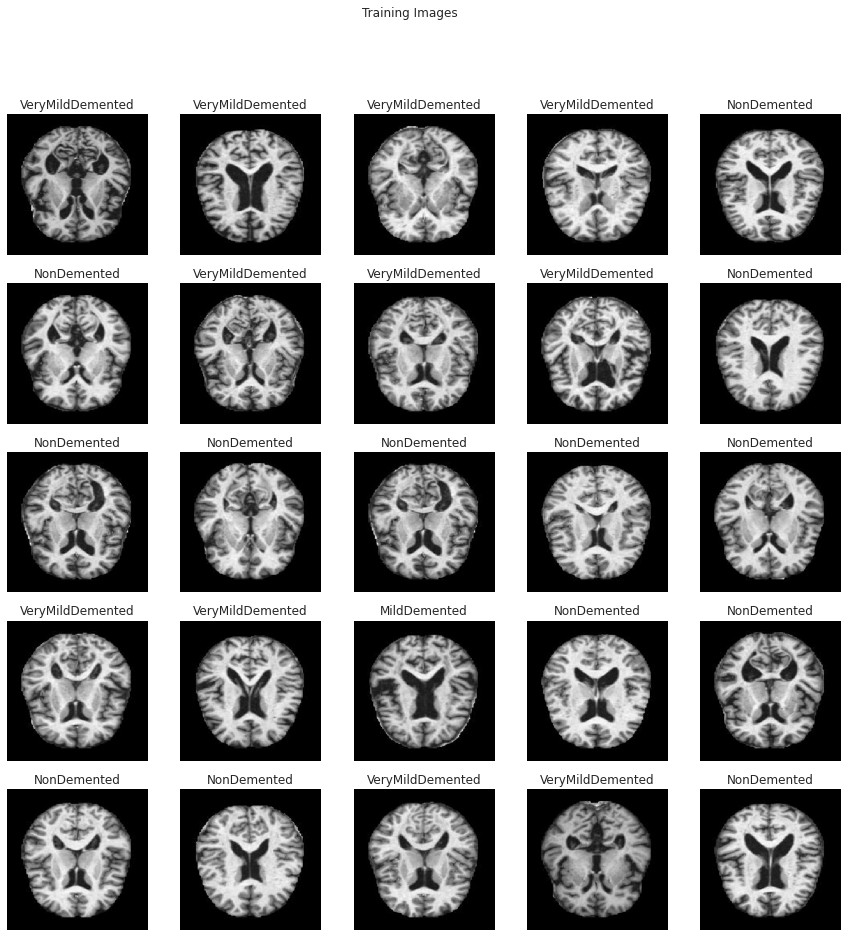

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (15,15))
for ax,img,label in zip(axs.flatten(),Train_Sample_Images,Train_Sample_labels): 
  ax.imshow(img)
  ax.axis('off')
  L = np.argmax(label)
  ax.title.set_text(Ind2ClassName[L])
plt.suptitle('Training Images')
plt.savefig(f"{Save}Train_Image_Samples.jpg")

## Show Samples Images and their labels from Testing set.

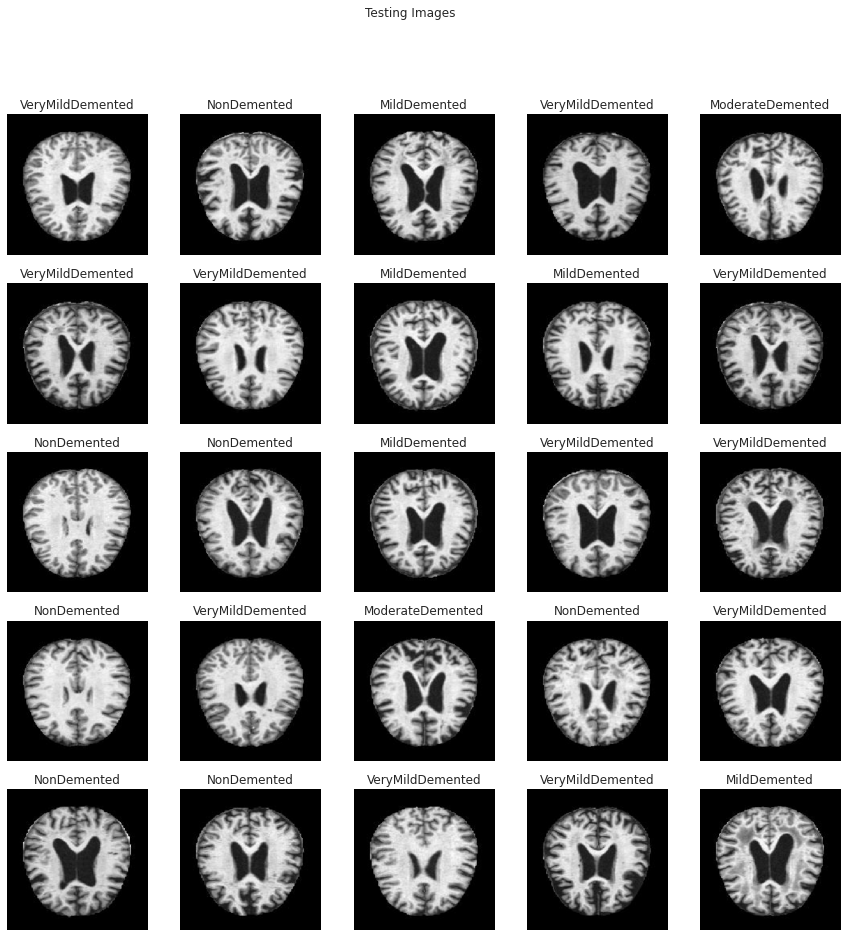

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (15,15))
for ax,img,label in zip(axs.flatten(),Test_Sample_Images,Test_Sample_labels): 
  ax.imshow(img)
  ax.axis('off')
  L = np.argmax(label)
  ax.title.set_text(Ind2ClassName[L])
plt.suptitle('Testing Images')
plt.savefig(f"{Save}Test_Image_Samples.jpg")

## Show Samples Images and their labels from Validation set.

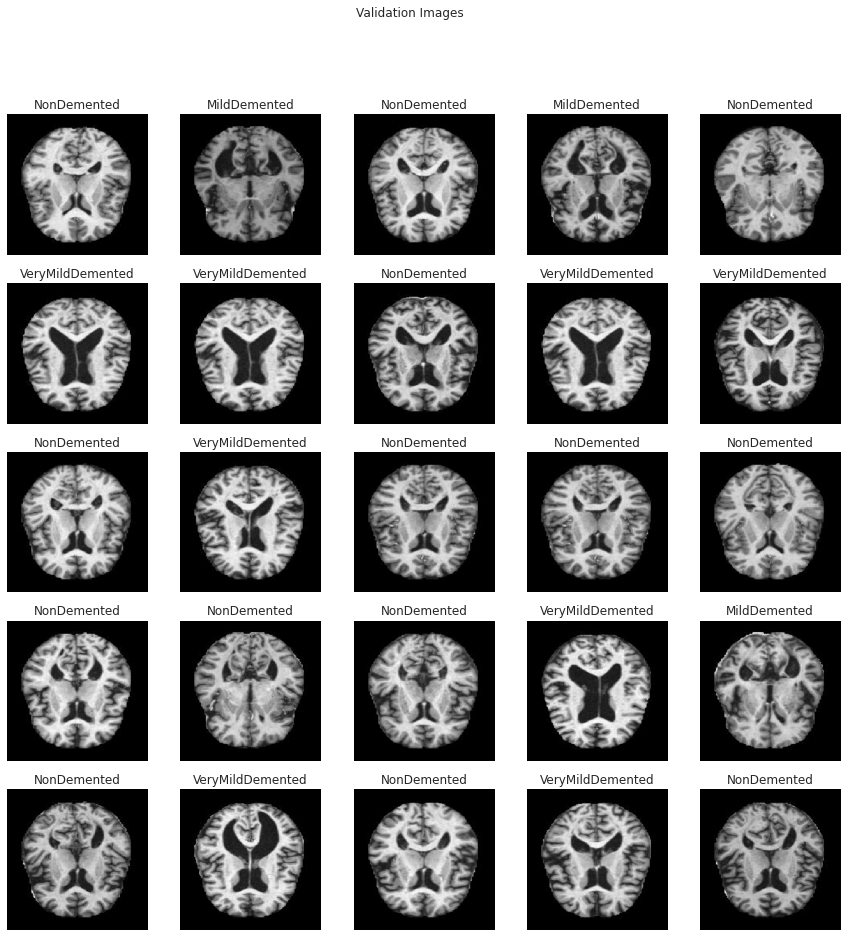

In [ ]:
fig, axs = plt.subplots(5, 5, figsize = (15,15))
for ax,img,label in zip(axs.flatten(),Valid_Sample_Images,Valid_Sample_labels): 
  ax.imshow(img)
  ax.axis('off')
  L = np.argmax(label)
  ax.title.set_text(Ind2ClassName[L])
plt.suptitle('Validation Images')
plt.savefig(f"{Save}validation_Image_Samples.jpg")

In [ ]:
print(f"Shape of an Image : {Train_Sample_Images[0].shape}")

Shape of an Image : (256, 256, 3)


## Data Distribution Count by Label 

## Count_plot ,  A function to count the number of samples belonging to each class and plot the counts by class in a barplot.

In [ ]:
def Count_plot(data_path, title, SavePath, fname):
  Count = {
      'NonDemented'     : 0, 
      'VeryMildDemented': 0, 
      'MildDemented'    : 0,
      'ModerateDemented': 0
      }

  for cls in os.listdir(data_path):
      for img in os.listdir(data_path + cls):
          Count[cls] = Count[cls] + 1

  keys = list(Count.keys())
  values = list(Count.values())  
  fig = plt.figure(figsize = (10, 5))
  plt.bar(keys, values, color=(0.2, 0.4, 0.6, 0.6), width = 0.4)
  plt.title(f"{title}")
  plt.savefig(f"{SavePath}{fname}")

## Total Number of Images by class in Training Set.

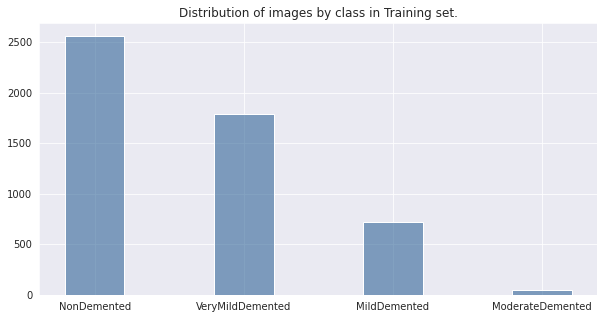

In [ ]:
Count_plot(train, "Distribution of images by class in Training set.", Save, "Training_distrib.jpeg")

## Total Number of Images by class in Test Set.

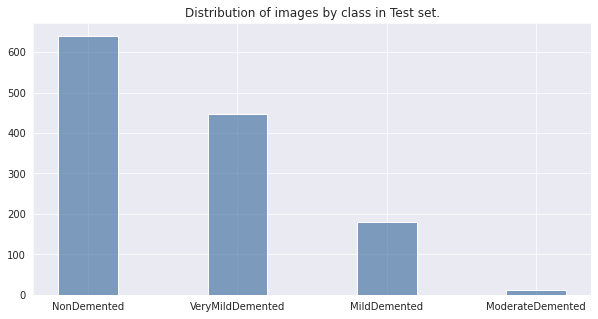

In [ ]:
Count_plot(test, "Distribution of images by class in Test set.", Save, "Testing_distrib.jpeg")